# CycleGAN完整训练、测试流程

In [ ]:
# 导入必要的库
import os
import functools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import itertools
import random
from torchvision import transforms
from torch.nn import init
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 1.参数设置

In [ ]:
# 定义所有参数（超参数、数据路径、模型设置等）
# 训练参数
batch_size = 1  # CycleGAN通常使用batch_size=1
epochs = 200
lr = 0.0002
beta1 = 0.5
pool_size = 50  # 历史缓冲区大小

# 损失权重
lambda_cyc = 10.0  # 循环一致性损失权重
lambda_id = 0.5    # 身份损失权重

# 数据路径
data_root = 'face2genshin'  # 示例数据集
epochs_decay = 100  # 学习率开始衰减的epoch

# 模型参数
input_nc = 3       # 输入通道数（RGB）
output_nc = 3      # 输出通道数（RGB）
ngf = 64          # 生成器第一层通道数
ndf = 64          # 判别器第一层通道数
n_blocks = 9      # ResNet块数量

# 图像尺寸
crop_size = 256
load_size = 286

# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision('high')
    print(f"GPU设备: {torch.cuda.get_device_name()}")

使用设备: cuda
GPU设备: NVIDIA GeForce RTX 4060 Laptop GPU


| 参数名       | 含义说明                                                                 |
|--------------|--------------------------------------------------------------------------|
| batch_size   | 每个批次训练的图片数量          |
| epochs       | 总训练轮数                                                                |
| lr           | 学习率（初始）                                                            |
| beta1        | Adam优化器的一阶矩衰减系数 β1                                             |
| pool_size    | 判别器历史生成样本池大小                       |
| lambda_cyc   | 循环一致性损失的权重                                                      |
| lambda_id    | 身份（Identity）损失的权重                                                |
| data_root    | 数据集根目录                 |
| epochs_decay | 学习率开始线性衰减的轮数（从该轮起逐步衰减到 0）                          |
| input_nc     | 输入图像通道数（RGB=3）                                                   |
| output_nc    | 输出图像通道数（RGB=3）                                                   |
| ngf          | 生成器第一层卷积通道数（通道基数，影响模型容量）                          |
| ndf          | 判别器第一层卷积通道数（通道基数，影响判别能力）                          |
| n_blocks     | 生成器中 ResNet 残差块数量                                                |
| crop_size    | 图像随机裁剪后的尺寸                            |
| load_size    | 图像加载/缩放到的尺寸                   |

## 2.数据准备

In [ ]:
# 定义数据集类
class UnalignedDataset(Dataset):
    """非配对图像数据集"""
    
    def __init__(self, root_dir, transform=None, unaligned=False, max_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.unaligned = unaligned
        
        # 获取A域和B域的图像路径
        self.dir_A = os.path.join(root_dir, 'trainA')
        self.dir_B = os.path.join(root_dir, 'trainB')
        
        self.A_paths = []
        self.B_paths = []
        
        # 收集所有图像文件
        for path in [self.dir_A, self.dir_B]:
            if not os.path.exists(path):
                print(f"警告：路径不存在 {path}")
                continue
                
            for filename in os.listdir(path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    if path == self.dir_A:
                        self.A_paths.append(os.path.join(path, filename))
                    else:
                        self.B_paths.append(os.path.join(path, filename))
        
        self.A_paths = sorted(self.A_paths)
        self.B_paths = sorted(self.B_paths)
        
        # 限制数据集大小
        if max_size is not None:
            self.A_paths = self.A_paths[:min(len(self.A_paths), max_size)]
            self.B_paths = self.B_paths[:min(len(self.B_paths), max_size)]
        
        self.A_size = len(self.A_paths)
        self.B_size = len(self.B_paths)
        
        print(f"数据集A: {self.A_size}张图像")
        print(f"数据集B: {self.B_size}张图像")
    
    def __len__(self):
        return max(self.A_size, self.B_size)
    
    def __getitem__(self, index):
        A_path = self.A_paths[index % self.A_size]
        
        if self.unaligned:
            # 随机选择B域的图像
            index_B = random.randint(0, self.B_size - 1)
        else:
            # 顺序选择B域的图像
            index_B = index % self.B_size
        
        B_path = self.B_paths[index_B]
        
        # 读取图像
        A_img = Image.open(A_path).convert('RGB')
        B_img = Image.open(B_path).convert('RGB')
        
        # 应用变换
        if self.transform:
            A = self.transform(A_img)
            B = self.transform(B_img)
        else:
            A = A_img
            B = B_img
        
        return {'A': A, 'B': B, 'A_paths': A_path, 'B_paths': B_path}


In [ ]:
# 定义图像变换
transform = transforms.Compose([
    transforms.Resize(load_size, Image.BICUBIC),
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化到[-1, 1]
])

# 创建测试专用的确定性变换
test_transform = transforms.Compose([
    transforms.Resize(crop_size, Image.BICUBIC),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化到[-1, 1]
])

# 创建数据集和数据加载器
dataset = UnalignedDataset(data_root, transform=transform, unaligned=True)
num_workers = min(16, os.cpu_count() or 1)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=num_workers > 0,
    prefetch_factor=2 if num_workers > 0 else None
)
print(f"数据加载成功，数据集大小: {len(dataset)}")

数据集A: 777张图像
数据集B: 777张图像
数据加载成功，数据集大小: 777


## 3.模型结构

In [5]:
# 定义ResNet块
class ResnetBlock(nn.Module):
    """ResNet块"""
    
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
            norm_layer(dim),
            nn.ReLU(True)
        )
        
        if use_dropout:
            self.conv_block.add_module('dropout', nn.Dropout(0.5))
            
        self.conv_block.add_module('conv2', 
            nn.Sequential(
                nn.ReflectionPad2d(1),
                nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=use_bias),
                norm_layer(dim)
            )
        )
    
    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [6]:
# 定义生成器（ResNet-based）
class ResnetGenerator(nn.Module):
    """基于ResNet的生成器"""
    
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9, 
                 padding_type='reflect', norm_layer=nn.InstanceNorm2d, 
                 use_dropout=False, use_bias=False):
        super(ResnetGenerator, self).__init__()
        
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
            norm_layer(ngf),
            nn.ReLU(True)
        ]
        
        # 下采样
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                         stride=2, padding=1, bias=use_bias),
                norm_layer(ngf * mult * 2),
                nn.ReLU(True)
            ]
        
        # ResNet块
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [
                ResnetBlock(ngf * mult, padding_type=padding_type, 
                           norm_layer=norm_layer, use_dropout=use_dropout, 
                           use_bias=use_bias)
            ]
        
        # 上采样
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                  kernel_size=3, stride=2, padding=1,
                                  output_padding=1, bias=use_bias),
                norm_layer(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]
        
        # 输出层
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, input):
        return self.model(input)

In [7]:
# 定义判别器（PatchGAN）
class NLayerDiscriminator(nn.Module):
    """PatchGAN判别器"""
    
    def __init__(self, input_nc, ndf=64, n_layers=3, 
                 norm_layer=nn.InstanceNorm2d, use_sigmoid=False):
        super(NLayerDiscriminator, self).__init__()
        
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True)
        ]
        
        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                         kernel_size=4, stride=2, padding=1, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        
        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                     kernel_size=4, stride=1, padding=1, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        
        sequence += [
            nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=1)
        ]
        
        if use_sigmoid:
            sequence += [nn.Sigmoid()]
        
        self.model = nn.Sequential(*sequence)
    
    def forward(self, input):
        return self.model(input)

In [8]:
# 定义历史图像缓冲区
class ImagePool:
    """历史图像缓冲区，用于存储历史生成的图像"""
    
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []
    
    def query(self, images):
        """从缓冲区获取图像，有50%概率返回最新图像，50%概率返回历史图像"""
        if self.pool_size == 0:
            return images
        
        return_images = []
        for image in images:
            # 使用.data切断计算图，避免显存泄漏
            image = image.unsqueeze(0).detach().clone()
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                if random.uniform(0, 1) > 0.5:
                    random_id = random.randint(0, self.pool_size - 1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        
        return_images = torch.cat(return_images, 0)
        return return_images

In [9]:
# 初始化模型

# 创建生成器
netG_A = ResnetGenerator(input_nc, output_nc, ngf, n_blocks).to(device)
netG_B = ResnetGenerator(output_nc, input_nc, ngf, n_blocks).to(device)

# 创建判别器
netD_A = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=nn.InstanceNorm2d).to(device)
netD_B = NLayerDiscriminator(output_nc, ndf, n_layers=3, norm_layer=nn.InstanceNorm2d).to(device)

# 初始化权重
def weights_init(m):
    """初始化模型权重"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0)

netG_A.apply(weights_init)
netG_B.apply(weights_init)
netD_A.apply(weights_init)
netD_B.apply(weights_init)

print(f"生成器A参数数量: {sum(p.numel() for p in netG_A.parameters())}")
print(f"生成器B参数数量: {sum(p.numel() for p in netG_B.parameters())}")
print(f"判别器A参数数量: {sum(p.numel() for p in netD_A.parameters())}")
print(f"判别器B参数数量: {sum(p.numel() for p in netD_B.parameters())}")


生成器A参数数量: 11372931
生成器B参数数量: 11372931
判别器A参数数量: 2764737
判别器B参数数量: 2764737


## 4.训练目标

In [10]:
# 定义损失函数
criterionGAN = nn.MSELoss()  # LSGAN损失
criterionCycle = nn.L1Loss()  # 循环一致性损失
criterionIdt = nn.L1Loss()    # 身份损失

# 创建图像缓冲区
fake_A_pool = ImagePool(pool_size)
fake_B_pool = ImagePool(pool_size)

# 定义优化器
optimizer_G = optim.Adam(itertools.chain(netG_A.parameters(), netG_B.parameters()),
                        lr=lr, betas=(beta1, 0.999))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=lr, betas=(beta1, 0.999))

# 学习率调度器
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=lambda epoch: 1.0 - max(0, epoch + 1 - epochs_decay) / (epochs - epochs_decay))
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=lambda epoch: 1.0 - max(0, epoch + 1 - epochs_decay) / (epochs - epochs_decay))
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=lambda epoch: 1.0 - max(0, epoch + 1 - epochs_decay) / (epochs - epochs_decay))

amp_enabled = device.type == 'cuda'
scaler_G = GradScaler(enabled=amp_enabled)
scaler_D_A = GradScaler(enabled=amp_enabled)
scaler_D_B = GradScaler(enabled=amp_enabled)

In [11]:
# 创建保存目录
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('results/cyclegan', exist_ok=True)

# 训练历史记录
losses_history = {
    'G_A': [],
    'G_B': [],
    'D_A': [],
    'D_B': [],
    'cycle_A': [],
    'cycle_B': [],
    'idt_A': [],
    'idt_B': []
}

In [12]:
# 定义GAN损失计算函数
def cal_gen_loss(netD, fake, real):
    """计算生成器的对抗损失"""
    pred_fake = netD(fake)
    target_real = torch.ones_like(pred_fake)
    loss_GAN = criterionGAN(pred_fake, target_real)
    return loss_GAN

def cal_disc_loss(netD, real, fake):
    """计算判别器的损失"""
    # 真实图像的损失
    pred_real = netD(real)
    target_real = torch.ones_like(pred_real)
    loss_D_real = criterionGAN(pred_real, target_real)
    
    # 生成图像的损失
    pred_fake = netD(fake.detach())
    target_fake = torch.zeros_like(pred_fake)
    loss_D_fake = criterionGAN(pred_fake, target_fake)
    
    # 总损失
    loss_D = (loss_D_real + loss_D_fake) * 0.5
    return loss_D

下面这个单元格模块用于保证演示的完整性。由于本地 4060 显卡训练速度较慢，我们先在云端 GPU 上预先训练了 300 轮。为了便于 Notebook 的完整演示，这里在已有 300 轮的基础上继续本地训练 150 轮，实现无缝衔接与功能补充。

In [13]:
# 加载预训练模型（如果存在）
def load_checkpoint(checkpoint_path, netG_A, netG_B, netD_A, netD_B):
    """加载检查点文件"""
    if os.path.exists(checkpoint_path):
        print(f"正在加载检查点: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        # 加载模型权重
        netG_A.load_state_dict(checkpoint['netG_A'])
        netG_B.load_state_dict(checkpoint['netG_B'])
        netD_A.load_state_dict(checkpoint['netD_A'])
        netD_B.load_state_dict(checkpoint['netD_B'])
        
        # 加载损失历史
        if 'losses_history' in checkpoint:
            global losses_history
            losses_history = checkpoint['losses_history']
            print(f"已加载 {checkpoint['epoch']} 轮的训练历史记录")
        
        start_epoch = checkpoint.get('epoch', 0)
        print(f"成功加载模型，将从第 {start_epoch} 轮继续训练")
        return start_epoch
    else:
        print(f"检查点文件不存在: {checkpoint_path}")
        print("将从零开始训练")
        return 0

# 尝试加载最新的检查点
checkpoint_paths = ['checkpoints/cyclegan_final.pth']

start_epoch = 0
for checkpoint_path in checkpoint_paths:
    if os.path.exists(checkpoint_path):
        start_epoch = load_checkpoint(checkpoint_path, netG_A, netG_B, netD_A, netD_B)
        if start_epoch > 0:
            break

# 如果加载了模型，更新训练轮数
if start_epoch > 0:
    # 额外训练的轮数
    epochs = start_epoch + 150
    total_additional_epochs = epochs - start_epoch
    print(f"将额外训练 {total_additional_epochs} 轮")

正在加载检查点: checkpoints/cyclegan_final.pth
已加载 300 轮的训练历史记录
成功加载模型，将从第 300 轮继续训练
将额外训练 150 轮


## 5.开始训练

In [ ]:
# 训练CycleGAN模型
print(f"开始训练CycleGAN，总轮数: {epochs} (从第 {start_epoch+1} 轮开始)")

# 从start_epoch开始
for epoch in range(start_epoch, epochs):
    epoch_losses = {k: 0.0 for k in losses_history.keys()}
    num_batches = 0
    
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
    for i, data in enumerate(pbar):
        # 获取真实图像
        real_A = data['A'].to(device)
        real_B = data['B'].to(device)
        
        # 前向传播
        # G_A: A -> B
        fake_B = netG_A(real_A)
        # G_B: B -> A
        fake_A = netG_B(real_B)
        # 循环重建
        rec_A = netG_B(fake_B)
        rec_B = netG_A(fake_A)
        # 更新生成器
        optimizer_G.zero_grad(set_to_none=True)
        
        with autocast('cuda', enabled=amp_enabled):
            # GAN损失 D_A(G_A(A))
            loss_GAN_A = cal_gen_loss(netD_A, fake_B, real_B)
            # GAN损失 D_B(G_B(B))
            loss_GAN_B = cal_gen_loss(netD_B, fake_A, real_A)
            # 循环一致性损失
            loss_cycle_A = criterionCycle(rec_A, real_A) * lambda_cyc
            loss_cycle_B = criterionCycle(rec_B, real_B) * lambda_cyc
            # 身份损失
            idt_A = netG_A(real_B)
            idt_B = netG_B(real_A)
            loss_idt_A = criterionIdt(idt_A, real_B) * lambda_cyc * lambda_id
            loss_idt_B = criterionIdt(idt_B, real_A) * lambda_cyc * lambda_id
            loss_G = loss_GAN_A + loss_GAN_B + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B
        
        scaler_G.scale(loss_G).backward()
        scaler_G.step(optimizer_G)
        scaler_G.update()
        
        # 更新判别器 A
        optimizer_D_A.zero_grad(set_to_none=True)
        with autocast('cuda', enabled=amp_enabled):
            loss_D_A = cal_disc_loss(netD_A, real_B, fake_B_pool.query(fake_B))
        scaler_D_A.scale(loss_D_A).backward()
        scaler_D_A.step(optimizer_D_A)
        scaler_D_A.update()
        
        # 更新判别器 B
        optimizer_D_B.zero_grad(set_to_none=True)
        with autocast('cuda', enabled=amp_enabled):
            loss_D_B = cal_disc_loss(netD_B, real_A, fake_A_pool.query(fake_A))
        scaler_D_B.scale(loss_D_B).backward()
        scaler_D_B.step(optimizer_D_B)
        scaler_D_B.update()
        
        # 记录损失
        epoch_losses['G_A'] += loss_GAN_A.item()
        epoch_losses['G_B'] += loss_GAN_B.item()
        epoch_losses['D_A'] += loss_D_A.item()
        epoch_losses['D_B'] += loss_D_B.item()
        epoch_losses['cycle_A'] += loss_cycle_A.item()
        epoch_losses['cycle_B'] += loss_cycle_B.item()
        epoch_losses['idt_A'] += loss_idt_A.item()
        epoch_losses['idt_B'] += loss_idt_B.item()
        num_batches += 1
        
        # 更新进度条
        pbar.set_postfix({
            'G_loss': (loss_GAN_A + loss_GAN_B).item(),
            'D_loss': (loss_D_A + loss_D_B).item(),
            'C_loss': (loss_cycle_A + loss_cycle_B).item()
        })
    
    # 计算平均损失
    for key in epoch_losses:
        epoch_losses[key] /= num_batches
        losses_history[key].append(epoch_losses[key])
    
    # 更新学习率
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # 打印epoch信息
    print(f"Epoch {epoch+1}/{epochs} - "
          f"G_A: {epoch_losses['G_A']:.4f}, G_B: {epoch_losses['G_B']:.4f}, "
          f"D_A: {epoch_losses['D_A']:.4f}, D_B: {epoch_losses['D_B']:.4f}, "
          f"Cycle_A: {epoch_losses['cycle_A']:.4f}, Cycle_B: {epoch_losses['cycle_B']:.4f}")


开始训练CycleGAN，总轮数: 450 (从第 301 轮开始)


Epoch 301/450: 100%|██████████| 777/777 [03:04<00:00,  4.22it/s, G_loss=1.57, D_loss=0.894, C_loss=2.69]  


Epoch 301/450 - G_A: 0.5716, G_B: 0.5409, D_A: 0.1989, D_B: 0.2125, Cycle_A: 1.6398, Cycle_B: 1.7211


Epoch 302/450: 100%|██████████| 777/777 [03:01<00:00,  4.29it/s, G_loss=1.2, D_loss=0.124, C_loss=3.04]  


Epoch 302/450 - G_A: 0.5174, G_B: 0.5084, D_A: 0.1639, D_B: 0.1811, Cycle_A: 1.5356, Cycle_B: 1.5194


Epoch 303/450: 100%|██████████| 777/777 [03:00<00:00,  4.30it/s, G_loss=0.986, D_loss=0.571, C_loss=3.6] 


Epoch 303/450 - G_A: 0.5293, G_B: 0.5202, D_A: 0.1668, D_B: 0.1699, Cycle_A: 1.5327, Cycle_B: 1.5523


Epoch 304/450: 100%|██████████| 777/777 [03:00<00:00,  4.30it/s, G_loss=1.02, D_loss=0.273, C_loss=3.46] 


Epoch 304/450 - G_A: 0.5077, G_B: 0.4970, D_A: 0.1692, D_B: 0.1727, Cycle_A: 1.4990, Cycle_B: 1.4911


Epoch 305/450: 100%|██████████| 777/777 [03:02<00:00,  4.26it/s, G_loss=0.432, D_loss=0.344, C_loss=1.91] 


Epoch 305/450 - G_A: 0.5018, G_B: 0.5063, D_A: 0.1630, D_B: 0.1691, Cycle_A: 1.4768, Cycle_B: 1.5052


Epoch 306/450: 100%|██████████| 777/777 [03:00<00:00,  4.30it/s, G_loss=0.177, D_loss=0.604, C_loss=3.69]


Epoch 306/450 - G_A: 0.5168, G_B: 0.4991, D_A: 0.1635, D_B: 0.1693, Cycle_A: 1.4552, Cycle_B: 1.4923


Epoch 307/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.881, D_loss=0.504, C_loss=1.74]


Epoch 307/450 - G_A: 0.5181, G_B: 0.5072, D_A: 0.1598, D_B: 0.1644, Cycle_A: 1.4148, Cycle_B: 1.4337


Epoch 308/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.801, D_loss=0.181, C_loss=2.47]


Epoch 308/450 - G_A: 0.5159, G_B: 0.5043, D_A: 0.1564, D_B: 0.1582, Cycle_A: 1.4091, Cycle_B: 1.4514


Epoch 309/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.39, D_loss=0.278, C_loss=3.82] 


Epoch 309/450 - G_A: 0.4927, G_B: 0.5034, D_A: 0.1642, D_B: 0.1619, Cycle_A: 1.3982, Cycle_B: 1.4016


Epoch 310/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.308, D_loss=0.455, C_loss=3.79]


Epoch 310/450 - G_A: 0.5044, G_B: 0.4899, D_A: 0.1640, D_B: 0.1642, Cycle_A: 1.3711, Cycle_B: 1.4115


Epoch 311/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.21, D_loss=0.255, C_loss=2.01] 


Epoch 311/450 - G_A: 0.5099, G_B: 0.5097, D_A: 0.1591, D_B: 0.1635, Cycle_A: 1.3916, Cycle_B: 1.4342


Epoch 312/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.35, D_loss=0.216, C_loss=3.56]  


Epoch 312/450 - G_A: 0.5007, G_B: 0.4819, D_A: 0.1617, D_B: 0.1590, Cycle_A: 1.3213, Cycle_B: 1.4064


Epoch 313/450: 100%|██████████| 777/777 [03:01<00:00,  4.27it/s, G_loss=0.829, D_loss=0.406, C_loss=2.46] 


Epoch 313/450 - G_A: 0.4977, G_B: 0.5002, D_A: 0.1577, D_B: 0.1593, Cycle_A: 1.3356, Cycle_B: 1.3925


Epoch 314/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.796, D_loss=0.355, C_loss=1.98]


Epoch 314/450 - G_A: 0.5134, G_B: 0.4947, D_A: 0.1504, D_B: 0.1562, Cycle_A: 1.3291, Cycle_B: 1.4062


Epoch 315/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.548, D_loss=0.333, C_loss=1.81]


Epoch 315/450 - G_A: 0.4906, G_B: 0.3778, D_A: 0.1581, D_B: 0.2901, Cycle_A: 1.3002, Cycle_B: 1.2454


Epoch 316/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.783, D_loss=0.146, C_loss=3.42] 


Epoch 316/450 - G_A: 0.4903, G_B: 0.4255, D_A: 0.1548, D_B: 0.1535, Cycle_A: 1.2909, Cycle_B: 1.2692


Epoch 317/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.48, D_loss=0.282, C_loss=2.43]  


Epoch 317/450 - G_A: 0.4885, G_B: 0.4666, D_A: 0.1529, D_B: 0.1558, Cycle_A: 1.3045, Cycle_B: 1.3081


Epoch 318/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.452, D_loss=0.369, C_loss=2.12]


Epoch 318/450 - G_A: 0.5211, G_B: 0.4791, D_A: 0.1525, D_B: 0.1616, Cycle_A: 1.2807, Cycle_B: 1.3118


Epoch 319/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.765, D_loss=0.295, C_loss=2.28]


Epoch 319/450 - G_A: 0.5088, G_B: 0.4807, D_A: 0.1550, D_B: 0.1648, Cycle_A: 1.2643, Cycle_B: 1.2996


Epoch 320/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.34, D_loss=0.167, C_loss=2.51] 


Epoch 320/450 - G_A: 0.4990, G_B: 0.4786, D_A: 0.1540, D_B: 0.1620, Cycle_A: 1.2507, Cycle_B: 1.3022


Epoch 321/450: 100%|██████████| 777/777 [03:01<00:00,  4.27it/s, G_loss=0.847, D_loss=0.245, C_loss=3.4] 


Epoch 321/450 - G_A: 0.5103, G_B: 0.4700, D_A: 0.1551, D_B: 0.1650, Cycle_A: 1.2289, Cycle_B: 1.2923


Epoch 322/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.04, D_loss=0.202, C_loss=2.78]  


Epoch 322/450 - G_A: 0.5031, G_B: 0.4776, D_A: 0.1501, D_B: 0.1622, Cycle_A: 1.2415, Cycle_B: 1.2875


Epoch 323/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.15, D_loss=0.293, C_loss=4.27]  


Epoch 323/450 - G_A: 0.5067, G_B: 0.4638, D_A: 0.1515, D_B: 0.1628, Cycle_A: 1.2518, Cycle_B: 1.2387


Epoch 324/450: 100%|██████████| 777/777 [03:01<00:00,  4.28it/s, G_loss=1.41, D_loss=0.537, C_loss=2.95]  


Epoch 324/450 - G_A: 0.5023, G_B: 0.4609, D_A: 0.1551, D_B: 0.1665, Cycle_A: 1.2044, Cycle_B: 1.2353


Epoch 325/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.905, D_loss=0.163, C_loss=2.65] 


Epoch 325/450 - G_A: 0.5127, G_B: 0.4664, D_A: 0.1502, D_B: 0.1593, Cycle_A: 1.2170, Cycle_B: 1.2353


Epoch 326/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=2.18, D_loss=0.542, C_loss=1.66] 


Epoch 326/450 - G_A: 0.4982, G_B: 0.4925, D_A: 0.1532, D_B: 0.1580, Cycle_A: 1.2107, Cycle_B: 1.2488


Epoch 327/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.39, D_loss=0.294, C_loss=2.92]  


Epoch 327/450 - G_A: 0.5059, G_B: 0.4728, D_A: 0.1506, D_B: 0.1610, Cycle_A: 1.1872, Cycle_B: 1.2309


Epoch 328/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.741, D_loss=0.353, C_loss=1.82]


Epoch 328/450 - G_A: 0.4908, G_B: 0.4754, D_A: 0.1545, D_B: 0.1618, Cycle_A: 1.1818, Cycle_B: 1.2287


Epoch 329/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.07, D_loss=0.287, C_loss=1.9]  


Epoch 329/450 - G_A: 0.5001, G_B: 0.4849, D_A: 0.1498, D_B: 0.1587, Cycle_A: 1.1630, Cycle_B: 1.2052


Epoch 330/450: 100%|██████████| 777/777 [03:02<00:00,  4.27it/s, G_loss=0.782, D_loss=0.204, C_loss=2.02]


Epoch 330/450 - G_A: 0.4924, G_B: 0.4825, D_A: 0.1502, D_B: 0.1577, Cycle_A: 1.1820, Cycle_B: 1.2043


Epoch 331/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.879, D_loss=0.4, C_loss=2.15]   


Epoch 331/450 - G_A: 0.5008, G_B: 0.4857, D_A: 0.1547, D_B: 0.1568, Cycle_A: 1.1655, Cycle_B: 1.1969


Epoch 332/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.653, D_loss=0.514, C_loss=1.61]


Epoch 332/450 - G_A: 0.4799, G_B: 0.4843, D_A: 0.1520, D_B: 0.1608, Cycle_A: 1.1307, Cycle_B: 1.1708


Epoch 333/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.766, D_loss=0.147, C_loss=2.23]


Epoch 333/450 - G_A: 0.4936, G_B: 0.4878, D_A: 0.1501, D_B: 0.1604, Cycle_A: 1.1504, Cycle_B: 1.2027


Epoch 334/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.689, D_loss=0.388, C_loss=2.3] 


Epoch 334/450 - G_A: 0.4882, G_B: 0.4751, D_A: 0.1546, D_B: 0.1607, Cycle_A: 1.1176, Cycle_B: 1.1950


Epoch 335/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=1.09, D_loss=0.197, C_loss=2.21] 


Epoch 335/450 - G_A: 0.5007, G_B: 0.4792, D_A: 0.1479, D_B: 0.1591, Cycle_A: 1.1515, Cycle_B: 1.1935


Epoch 336/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.727, D_loss=0.137, C_loss=3.33] 


Epoch 336/450 - G_A: 0.5097, G_B: 0.4805, D_A: 0.1495, D_B: 0.1609, Cycle_A: 1.1345, Cycle_B: 1.1606


Epoch 337/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.687, D_loss=0.283, C_loss=2.15] 


Epoch 337/450 - G_A: 0.4864, G_B: 0.4688, D_A: 0.1529, D_B: 0.1589, Cycle_A: 1.1306, Cycle_B: 1.1460


Epoch 338/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.955, D_loss=0.252, C_loss=2.18] 


Epoch 338/450 - G_A: 0.5104, G_B: 0.4771, D_A: 0.1445, D_B: 0.1601, Cycle_A: 1.1300, Cycle_B: 1.1855


Epoch 339/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=1.67, D_loss=0.379, C_loss=1.77]  


Epoch 339/450 - G_A: 0.5067, G_B: 0.4653, D_A: 0.1441, D_B: 0.1625, Cycle_A: 1.1218, Cycle_B: 1.1327


Epoch 340/450: 100%|██████████| 777/777 [03:01<00:00,  4.28it/s, G_loss=1.35, D_loss=0.304, C_loss=2.61] 


Epoch 340/450 - G_A: 0.5205, G_B: 0.4791, D_A: 0.1471, D_B: 0.1615, Cycle_A: 1.1211, Cycle_B: 1.1411


Epoch 341/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.96, D_loss=0.334, C_loss=2.68]  


Epoch 341/450 - G_A: 0.5108, G_B: 0.4681, D_A: 0.1455, D_B: 0.1622, Cycle_A: 1.1198, Cycle_B: 1.1408


Epoch 342/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.978, D_loss=0.289, C_loss=2.55] 


Epoch 342/450 - G_A: 0.5185, G_B: 0.4673, D_A: 0.1430, D_B: 0.1592, Cycle_A: 1.1096, Cycle_B: 1.1352


Epoch 343/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.958, D_loss=0.342, C_loss=1.65] 


Epoch 343/450 - G_A: 0.5048, G_B: 0.4666, D_A: 0.1481, D_B: 0.1615, Cycle_A: 1.0878, Cycle_B: 1.1149


Epoch 344/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.829, D_loss=0.269, C_loss=2.04] 


Epoch 344/450 - G_A: 0.5052, G_B: 0.4720, D_A: 0.1451, D_B: 0.1633, Cycle_A: 1.0700, Cycle_B: 1.1123


Epoch 345/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.827, D_loss=0.23, C_loss=2.17] 


Epoch 345/450 - G_A: 0.5210, G_B: 0.4683, D_A: 0.1452, D_B: 0.1617, Cycle_A: 1.0877, Cycle_B: 1.1302


Epoch 346/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.762, D_loss=0.114, C_loss=1.73] 


Epoch 346/450 - G_A: 0.5061, G_B: 0.4720, D_A: 0.1420, D_B: 0.1631, Cycle_A: 1.0902, Cycle_B: 1.1215


Epoch 347/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.16, D_loss=0.208, C_loss=3.26] 


Epoch 347/450 - G_A: 0.5057, G_B: 0.4629, D_A: 0.1428, D_B: 0.1646, Cycle_A: 1.0688, Cycle_B: 1.1091


Epoch 348/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.682, D_loss=0.375, C_loss=1.54]


Epoch 348/450 - G_A: 0.5323, G_B: 0.4854, D_A: 0.1422, D_B: 0.1540, Cycle_A: 1.0606, Cycle_B: 1.1095


Epoch 349/450: 100%|██████████| 777/777 [03:01<00:00,  4.29it/s, G_loss=3.23, D_loss=0.374, C_loss=2.38] 


Epoch 349/450 - G_A: 0.5118, G_B: 0.4732, D_A: 0.1438, D_B: 0.1608, Cycle_A: 1.0595, Cycle_B: 1.1064


Epoch 350/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.906, D_loss=0.282, C_loss=2.09] 


Epoch 350/450 - G_A: 0.5190, G_B: 0.4733, D_A: 0.1373, D_B: 0.1627, Cycle_A: 1.0504, Cycle_B: 1.0860


Epoch 351/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.27, D_loss=0.556, C_loss=3.27] 


Epoch 351/450 - G_A: 0.5291, G_B: 0.4723, D_A: 0.1411, D_B: 0.1595, Cycle_A: 1.0595, Cycle_B: 1.1080


Epoch 352/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.09, D_loss=0.237, C_loss=3.44]  


Epoch 352/450 - G_A: 0.5171, G_B: 0.4798, D_A: 0.1356, D_B: 0.1584, Cycle_A: 1.0394, Cycle_B: 1.0835


Epoch 353/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.799, D_loss=0.306, C_loss=2.74]


Epoch 353/450 - G_A: 0.5109, G_B: 0.4629, D_A: 0.1357, D_B: 0.1570, Cycle_A: 1.0456, Cycle_B: 1.0549


Epoch 354/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.817, D_loss=0.35, C_loss=2.1]   


Epoch 354/450 - G_A: 0.5223, G_B: 0.4759, D_A: 0.1366, D_B: 0.1586, Cycle_A: 1.0185, Cycle_B: 1.0867


Epoch 355/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.954, D_loss=0.299, C_loss=2.21]


Epoch 355/450 - G_A: 0.5206, G_B: 0.4685, D_A: 0.1383, D_B: 0.1630, Cycle_A: 1.0244, Cycle_B: 1.0566


Epoch 356/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.682, D_loss=0.373, C_loss=2.4]  


Epoch 356/450 - G_A: 0.5272, G_B: 0.4735, D_A: 0.1364, D_B: 0.1605, Cycle_A: 1.0225, Cycle_B: 1.0545


Epoch 357/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.82, D_loss=0.198, C_loss=2]    


Epoch 357/450 - G_A: 0.5209, G_B: 0.4807, D_A: 0.1377, D_B: 0.1615, Cycle_A: 1.0321, Cycle_B: 1.0726


Epoch 358/450: 100%|██████████| 777/777 [03:01<00:00,  4.27it/s, G_loss=0.946, D_loss=0.201, C_loss=3.63] 


Epoch 358/450 - G_A: 0.5336, G_B: 0.4797, D_A: 0.1325, D_B: 0.1537, Cycle_A: 1.0164, Cycle_B: 1.0608


Epoch 359/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.09, D_loss=0.303, C_loss=2.54]  


Epoch 359/450 - G_A: 0.5303, G_B: 0.4931, D_A: 0.1347, D_B: 0.1563, Cycle_A: 1.0258, Cycle_B: 1.0607


Epoch 360/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.564, D_loss=0.417, C_loss=1.79]


Epoch 360/450 - G_A: 0.5506, G_B: 0.4763, D_A: 0.1308, D_B: 0.1595, Cycle_A: 1.0139, Cycle_B: 1.0591


Epoch 361/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.747, D_loss=0.328, C_loss=1.75]


Epoch 361/450 - G_A: 0.5179, G_B: 0.4707, D_A: 0.1407, D_B: 0.1608, Cycle_A: 0.9847, Cycle_B: 1.0347


Epoch 362/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.795, D_loss=0.266, C_loss=1.57] 


Epoch 362/450 - G_A: 0.5177, G_B: 0.4696, D_A: 0.1433, D_B: 0.1604, Cycle_A: 0.9820, Cycle_B: 1.0102


Epoch 363/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.606, D_loss=0.195, C_loss=1.47] 


Epoch 363/450 - G_A: 0.5203, G_B: 0.4833, D_A: 0.1391, D_B: 0.1615, Cycle_A: 0.9758, Cycle_B: 1.0348


Epoch 364/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.588, D_loss=0.383, C_loss=2.52]


Epoch 364/450 - G_A: 0.5387, G_B: 0.4631, D_A: 0.1369, D_B: 0.1635, Cycle_A: 0.9979, Cycle_B: 1.0455


Epoch 365/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.563, D_loss=0.248, C_loss=1.79]


Epoch 365/450 - G_A: 0.5232, G_B: 0.4658, D_A: 0.1352, D_B: 0.1580, Cycle_A: 0.9833, Cycle_B: 1.0291


Epoch 366/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.601, D_loss=0.282, C_loss=2.16]


Epoch 366/450 - G_A: 0.5299, G_B: 0.4767, D_A: 0.1345, D_B: 0.1592, Cycle_A: 0.9826, Cycle_B: 1.0170


Epoch 367/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.485, D_loss=0.271, C_loss=1.72] 


Epoch 367/450 - G_A: 0.5369, G_B: 0.4809, D_A: 0.1337, D_B: 0.1530, Cycle_A: 0.9892, Cycle_B: 1.0394


Epoch 368/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.23, D_loss=0.191, C_loss=1.73] 


Epoch 368/450 - G_A: 0.5243, G_B: 0.4818, D_A: 0.1372, D_B: 0.1607, Cycle_A: 0.9759, Cycle_B: 1.0052


Epoch 369/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.7, D_loss=0.278, C_loss=2.08]  


Epoch 369/450 - G_A: 0.5162, G_B: 0.4722, D_A: 0.1397, D_B: 0.1536, Cycle_A: 0.9580, Cycle_B: 1.0212


Epoch 370/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.14, D_loss=0.209, C_loss=1.9]   


Epoch 370/450 - G_A: 0.5150, G_B: 0.4787, D_A: 0.1375, D_B: 0.1586, Cycle_A: 0.9694, Cycle_B: 1.0265


Epoch 371/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.97, D_loss=0.0848, C_loss=3.06] 


Epoch 371/450 - G_A: 0.5256, G_B: 0.4714, D_A: 0.1384, D_B: 0.1592, Cycle_A: 0.9470, Cycle_B: 0.9919


Epoch 372/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.886, D_loss=0.22, C_loss=2.29]  


Epoch 372/450 - G_A: 0.5118, G_B: 0.4664, D_A: 0.1365, D_B: 0.1579, Cycle_A: 0.9645, Cycle_B: 1.0036


Epoch 373/450: 100%|██████████| 777/777 [03:02<00:00,  4.27it/s, G_loss=0.966, D_loss=0.299, C_loss=1.63]


Epoch 373/450 - G_A: 0.5402, G_B: 0.4646, D_A: 0.1302, D_B: 0.1624, Cycle_A: 0.9643, Cycle_B: 0.9775


Epoch 374/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.09, D_loss=0.245, C_loss=1.64] 


Epoch 374/450 - G_A: 0.5156, G_B: 0.4771, D_A: 0.1362, D_B: 0.1556, Cycle_A: 0.9580, Cycle_B: 1.0044


Epoch 375/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.836, D_loss=0.222, C_loss=1.99]


Epoch 375/450 - G_A: 0.5292, G_B: 0.4678, D_A: 0.1361, D_B: 0.1579, Cycle_A: 0.9465, Cycle_B: 0.9960


Epoch 376/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.758, D_loss=0.552, C_loss=2.84] 


Epoch 376/450 - G_A: 0.5169, G_B: 0.4692, D_A: 0.1386, D_B: 0.1598, Cycle_A: 0.9640, Cycle_B: 0.9940


Epoch 377/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.815, D_loss=0.431, C_loss=1.78] 


Epoch 377/450 - G_A: 0.4992, G_B: 0.4596, D_A: 0.1371, D_B: 0.1597, Cycle_A: 0.9319, Cycle_B: 0.9849


Epoch 378/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.918, D_loss=0.424, C_loss=1.82]


Epoch 378/450 - G_A: 0.5099, G_B: 0.4633, D_A: 0.1395, D_B: 0.1556, Cycle_A: 0.9379, Cycle_B: 0.9839


Epoch 379/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.26, D_loss=0.302, C_loss=1.96]  


Epoch 379/450 - G_A: 0.5187, G_B: 0.4783, D_A: 0.1414, D_B: 0.1589, Cycle_A: 0.9141, Cycle_B: 0.9901


Epoch 380/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.921, D_loss=0.239, C_loss=3.04] 


Epoch 380/450 - G_A: 0.5256, G_B: 0.4814, D_A: 0.1364, D_B: 0.1590, Cycle_A: 0.9364, Cycle_B: 0.9996


Epoch 381/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.32, D_loss=0.338, C_loss=1.86] 


Epoch 381/450 - G_A: 0.5309, G_B: 0.4756, D_A: 0.1341, D_B: 0.1574, Cycle_A: 0.9140, Cycle_B: 0.9720


Epoch 382/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.21, D_loss=0.522, C_loss=1.81] 


Epoch 382/450 - G_A: 0.5474, G_B: 0.4877, D_A: 0.1342, D_B: 0.1556, Cycle_A: 0.9386, Cycle_B: 1.0023


Epoch 383/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.633, D_loss=0.539, C_loss=1.48] 


Epoch 383/450 - G_A: 0.5427, G_B: 0.4617, D_A: 0.1311, D_B: 0.1632, Cycle_A: 0.9359, Cycle_B: 0.9875


Epoch 384/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.03, D_loss=0.311, C_loss=1.51]  


Epoch 384/450 - G_A: 0.5198, G_B: 0.4662, D_A: 0.1391, D_B: 0.1617, Cycle_A: 0.9150, Cycle_B: 0.9590


Epoch 385/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.35, D_loss=0.322, C_loss=1.76]  


Epoch 385/450 - G_A: 0.5171, G_B: 0.4756, D_A: 0.1422, D_B: 0.1562, Cycle_A: 0.9221, Cycle_B: 0.9764


Epoch 386/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.678, D_loss=0.115, C_loss=1.38]


Epoch 386/450 - G_A: 0.5244, G_B: 0.4728, D_A: 0.1364, D_B: 0.1587, Cycle_A: 0.9221, Cycle_B: 0.9528


Epoch 387/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=1.04, D_loss=0.158, C_loss=1.74]  


Epoch 387/450 - G_A: 0.5480, G_B: 0.4746, D_A: 0.1288, D_B: 0.1585, Cycle_A: 0.9272, Cycle_B: 0.9665


Epoch 388/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.76, D_loss=0.583, C_loss=1.55] 


Epoch 388/450 - G_A: 0.5147, G_B: 0.4550, D_A: 0.1341, D_B: 0.1603, Cycle_A: 0.9000, Cycle_B: 0.9692


Epoch 389/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=1.45, D_loss=0.133, C_loss=2.24]  


Epoch 389/450 - G_A: 0.5181, G_B: 0.4779, D_A: 0.1377, D_B: 0.1581, Cycle_A: 0.9206, Cycle_B: 0.9510


Epoch 390/450: 100%|██████████| 777/777 [03:02<00:00,  4.27it/s, G_loss=0.631, D_loss=0.221, C_loss=1.87] 


Epoch 390/450 - G_A: 0.5305, G_B: 0.4743, D_A: 0.1346, D_B: 0.1599, Cycle_A: 0.9005, Cycle_B: 0.9709


Epoch 391/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.33, D_loss=0.154, C_loss=1.78] 


Epoch 391/450 - G_A: 0.5188, G_B: 0.4666, D_A: 0.1371, D_B: 0.1618, Cycle_A: 0.9125, Cycle_B: 0.9236


Epoch 392/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.12, D_loss=0.267, C_loss=1.75] 


Epoch 392/450 - G_A: 0.5092, G_B: 0.4742, D_A: 0.1387, D_B: 0.1587, Cycle_A: 0.8756, Cycle_B: 0.9612


Epoch 393/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.32, D_loss=0.299, C_loss=1.43] 


Epoch 393/450 - G_A: 0.5363, G_B: 0.4538, D_A: 0.1356, D_B: 0.1632, Cycle_A: 0.9163, Cycle_B: 0.9476


Epoch 394/450: 100%|██████████| 777/777 [02:58<00:00,  4.34it/s, G_loss=1.61, D_loss=0.421, C_loss=1.57]  


Epoch 394/450 - G_A: 0.5352, G_B: 0.4621, D_A: 0.1323, D_B: 0.1586, Cycle_A: 0.8937, Cycle_B: 0.9502


Epoch 395/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.7, D_loss=0.208, C_loss=1.55]   


Epoch 395/450 - G_A: 0.5290, G_B: 0.4634, D_A: 0.1326, D_B: 0.1553, Cycle_A: 0.9002, Cycle_B: 0.9537


Epoch 396/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.27, D_loss=0.574, C_loss=1.48]  


Epoch 396/450 - G_A: 0.5354, G_B: 0.4672, D_A: 0.1286, D_B: 0.1591, Cycle_A: 0.8819, Cycle_B: 0.9373


Epoch 397/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.816, D_loss=0.31, C_loss=2.69] 


Epoch 397/450 - G_A: 0.5212, G_B: 0.4827, D_A: 0.1339, D_B: 0.1606, Cycle_A: 0.8900, Cycle_B: 0.9498


Epoch 398/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.856, D_loss=0.24, C_loss=2.01]  


Epoch 398/450 - G_A: 0.5205, G_B: 0.4670, D_A: 0.1381, D_B: 0.1570, Cycle_A: 0.8764, Cycle_B: 0.9316


Epoch 399/450: 100%|██████████| 777/777 [03:02<00:00,  4.27it/s, G_loss=0.637, D_loss=0.436, C_loss=2.36]


Epoch 399/450 - G_A: 0.5222, G_B: 0.4488, D_A: 0.1326, D_B: 0.1608, Cycle_A: 0.8582, Cycle_B: 0.9129


Epoch 400/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=1.1, D_loss=0.162, C_loss=1.72]   


Epoch 400/450 - G_A: 0.5058, G_B: 0.4531, D_A: 0.1371, D_B: 0.1627, Cycle_A: 0.8740, Cycle_B: 0.9156


Epoch 401/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.68, D_loss=0.201, C_loss=1.48]  


Epoch 401/450 - G_A: 0.5214, G_B: 0.4719, D_A: 0.1366, D_B: 0.1533, Cycle_A: 0.8896, Cycle_B: 0.9510


Epoch 402/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.78, D_loss=0.388, C_loss=1.57] 


Epoch 402/450 - G_A: 0.5277, G_B: 0.4746, D_A: 0.1314, D_B: 0.1618, Cycle_A: 0.8725, Cycle_B: 0.9301


Epoch 403/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.811, D_loss=0.325, C_loss=1.77]


Epoch 403/450 - G_A: 0.5176, G_B: 0.4664, D_A: 0.1329, D_B: 0.1610, Cycle_A: 0.8568, Cycle_B: 0.9124


Epoch 404/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=1.1, D_loss=0.554, C_loss=1.72]  


Epoch 404/450 - G_A: 0.5189, G_B: 0.4588, D_A: 0.1373, D_B: 0.1641, Cycle_A: 0.8502, Cycle_B: 0.9220


Epoch 405/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.928, D_loss=0.293, C_loss=2.14]


Epoch 405/450 - G_A: 0.5283, G_B: 0.4723, D_A: 0.1331, D_B: 0.1622, Cycle_A: 0.8587, Cycle_B: 0.9096


Epoch 406/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.673, D_loss=0.357, C_loss=1.61] 


Epoch 406/450 - G_A: 0.5163, G_B: 0.4719, D_A: 0.1348, D_B: 0.1581, Cycle_A: 0.8520, Cycle_B: 0.9094


Epoch 407/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.767, D_loss=0.226, C_loss=1.57] 


Epoch 407/450 - G_A: 0.5188, G_B: 0.4542, D_A: 0.1354, D_B: 0.1626, Cycle_A: 0.8478, Cycle_B: 0.8938


Epoch 408/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.06, D_loss=0.257, C_loss=1.73]  


Epoch 408/450 - G_A: 0.5366, G_B: 0.4506, D_A: 0.1311, D_B: 0.1590, Cycle_A: 0.8433, Cycle_B: 0.9094


Epoch 409/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.18, D_loss=0.202, C_loss=1.72]  


Epoch 409/450 - G_A: 0.5213, G_B: 0.4611, D_A: 0.1334, D_B: 0.1632, Cycle_A: 0.8547, Cycle_B: 0.8982


Epoch 410/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.409, D_loss=0.486, C_loss=1.68] 


Epoch 410/450 - G_A: 0.5319, G_B: 0.4656, D_A: 0.1302, D_B: 0.1611, Cycle_A: 0.8502, Cycle_B: 0.9056


Epoch 411/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.702, D_loss=0.214, C_loss=1.65] 


Epoch 411/450 - G_A: 0.5346, G_B: 0.4675, D_A: 0.1320, D_B: 0.1586, Cycle_A: 0.8416, Cycle_B: 0.8997


Epoch 412/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.571, D_loss=0.437, C_loss=1.24]


Epoch 412/450 - G_A: 0.5114, G_B: 0.4589, D_A: 0.1374, D_B: 0.1550, Cycle_A: 0.8451, Cycle_B: 0.8831


Epoch 413/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.46, D_loss=0.785, C_loss=1.71]  


Epoch 413/450 - G_A: 0.5294, G_B: 0.4744, D_A: 0.1333, D_B: 0.1566, Cycle_A: 0.8332, Cycle_B: 0.9048


Epoch 414/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.582, D_loss=0.433, C_loss=1.95] 


Epoch 414/450 - G_A: 0.5372, G_B: 0.4611, D_A: 0.1302, D_B: 0.1589, Cycle_A: 0.8370, Cycle_B: 0.9018


Epoch 415/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.25, D_loss=0.148, C_loss=1.7]   


Epoch 415/450 - G_A: 0.5338, G_B: 0.4682, D_A: 0.1282, D_B: 0.1605, Cycle_A: 0.8126, Cycle_B: 0.8852


Epoch 416/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.56, D_loss=0.285, C_loss=1.78] 


Epoch 416/450 - G_A: 0.5248, G_B: 0.4574, D_A: 0.1290, D_B: 0.1573, Cycle_A: 0.8251, Cycle_B: 0.8924


Epoch 417/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.72, D_loss=0.246, C_loss=1.9]   


Epoch 417/450 - G_A: 0.5282, G_B: 0.4638, D_A: 0.1334, D_B: 0.1591, Cycle_A: 0.8218, Cycle_B: 0.8793


Epoch 418/450: 100%|██████████| 777/777 [03:02<00:00,  4.27it/s, G_loss=1.43, D_loss=0.156, C_loss=1.55] 


Epoch 418/450 - G_A: 0.5211, G_B: 0.4583, D_A: 0.1314, D_B: 0.1608, Cycle_A: 0.8151, Cycle_B: 0.8924


Epoch 419/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.833, D_loss=0.319, C_loss=1.67] 


Epoch 419/450 - G_A: 0.5282, G_B: 0.4662, D_A: 0.1347, D_B: 0.1580, Cycle_A: 0.8060, Cycle_B: 0.8635


Epoch 420/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.761, D_loss=0.24, C_loss=1.48] 


Epoch 420/450 - G_A: 0.5242, G_B: 0.4606, D_A: 0.1312, D_B: 0.1560, Cycle_A: 0.8140, Cycle_B: 0.8892


Epoch 421/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.19, D_loss=0.253, C_loss=1.8]  


Epoch 421/450 - G_A: 0.5348, G_B: 0.4562, D_A: 0.1294, D_B: 0.1587, Cycle_A: 0.8229, Cycle_B: 0.8859


Epoch 422/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=1.07, D_loss=0.297, C_loss=1.63] 


Epoch 422/450 - G_A: 0.5476, G_B: 0.4654, D_A: 0.1305, D_B: 0.1583, Cycle_A: 0.8051, Cycle_B: 0.8625


Epoch 423/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.748, D_loss=0.235, C_loss=1.23] 


Epoch 423/450 - G_A: 0.5226, G_B: 0.4637, D_A: 0.1290, D_B: 0.1551, Cycle_A: 0.8021, Cycle_B: 0.8723


Epoch 424/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.543, D_loss=0.325, C_loss=1.59]


Epoch 424/450 - G_A: 0.5176, G_B: 0.4610, D_A: 0.1371, D_B: 0.1603, Cycle_A: 0.7959, Cycle_B: 0.8673


Epoch 425/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.419, D_loss=0.509, C_loss=1.71] 


Epoch 425/450 - G_A: 0.5315, G_B: 0.4570, D_A: 0.1293, D_B: 0.1578, Cycle_A: 0.7883, Cycle_B: 0.8786


Epoch 426/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=1.29, D_loss=0.352, C_loss=1.6]   


Epoch 426/450 - G_A: 0.5315, G_B: 0.4624, D_A: 0.1272, D_B: 0.1554, Cycle_A: 0.7797, Cycle_B: 0.8534


Epoch 427/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.03, D_loss=0.281, C_loss=1.99]  


Epoch 427/450 - G_A: 0.5299, G_B: 0.4515, D_A: 0.1280, D_B: 0.1589, Cycle_A: 0.8000, Cycle_B: 0.8597


Epoch 428/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.854, D_loss=0.204, C_loss=1.52]


Epoch 428/450 - G_A: 0.5167, G_B: 0.4632, D_A: 0.1307, D_B: 0.1581, Cycle_A: 0.7785, Cycle_B: 0.8586


Epoch 429/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.27, D_loss=0.201, C_loss=1.54] 


Epoch 429/450 - G_A: 0.5298, G_B: 0.4580, D_A: 0.1265, D_B: 0.1566, Cycle_A: 0.7831, Cycle_B: 0.8420


Epoch 430/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.893, D_loss=0.236, C_loss=1.39] 


Epoch 430/450 - G_A: 0.5216, G_B: 0.4573, D_A: 0.1322, D_B: 0.1598, Cycle_A: 0.7792, Cycle_B: 0.8565


Epoch 431/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.73, D_loss=0.405, C_loss=1.72]  


Epoch 431/450 - G_A: 0.5177, G_B: 0.4613, D_A: 0.1305, D_B: 0.1603, Cycle_A: 0.7817, Cycle_B: 0.8515


Epoch 432/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=1.25, D_loss=0.233, C_loss=2.21]  


Epoch 432/450 - G_A: 0.5379, G_B: 0.4621, D_A: 0.1273, D_B: 0.1592, Cycle_A: 0.7787, Cycle_B: 0.8478


Epoch 433/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.26, D_loss=0.371, C_loss=2.23]  


Epoch 433/450 - G_A: 0.5287, G_B: 0.4557, D_A: 0.1332, D_B: 0.1576, Cycle_A: 0.7742, Cycle_B: 0.8543


Epoch 434/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.597, D_loss=0.394, C_loss=1.86]


Epoch 434/450 - G_A: 0.5468, G_B: 0.4548, D_A: 0.1228, D_B: 0.1575, Cycle_A: 0.7741, Cycle_B: 0.8504


Epoch 435/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.2, D_loss=0.549, C_loss=1.48]   


Epoch 435/450 - G_A: 0.5221, G_B: 0.4545, D_A: 0.1326, D_B: 0.1586, Cycle_A: 0.7512, Cycle_B: 0.8366


Epoch 436/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.535, D_loss=0.471, C_loss=1.48] 


Epoch 436/450 - G_A: 0.5250, G_B: 0.4567, D_A: 0.1314, D_B: 0.1580, Cycle_A: 0.7579, Cycle_B: 0.8333


Epoch 437/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.986, D_loss=0.541, C_loss=1.7]  


Epoch 437/450 - G_A: 0.5292, G_B: 0.4560, D_A: 0.1297, D_B: 0.1588, Cycle_A: 0.7634, Cycle_B: 0.8393


Epoch 438/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.851, D_loss=0.383, C_loss=1.64] 


Epoch 438/450 - G_A: 0.5386, G_B: 0.4615, D_A: 0.1323, D_B: 0.1593, Cycle_A: 0.7595, Cycle_B: 0.8335


Epoch 439/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=0.687, D_loss=0.281, C_loss=1.33]


Epoch 439/450 - G_A: 0.5405, G_B: 0.4616, D_A: 0.1298, D_B: 0.1580, Cycle_A: 0.7603, Cycle_B: 0.8388


Epoch 440/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.11, D_loss=0.17, C_loss=1.41]   


Epoch 440/450 - G_A: 0.5304, G_B: 0.4664, D_A: 0.1300, D_B: 0.1609, Cycle_A: 0.7431, Cycle_B: 0.8216


Epoch 441/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.465, D_loss=0.382, C_loss=1.96] 


Epoch 441/450 - G_A: 0.5524, G_B: 0.4574, D_A: 0.1255, D_B: 0.1555, Cycle_A: 0.7535, Cycle_B: 0.8324


Epoch 442/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.63, D_loss=0.269, C_loss=1.72] 


Epoch 442/450 - G_A: 0.5437, G_B: 0.4671, D_A: 0.1252, D_B: 0.1582, Cycle_A: 0.7654, Cycle_B: 0.8221


Epoch 443/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.768, D_loss=0.419, C_loss=1.58] 


Epoch 443/450 - G_A: 0.5439, G_B: 0.4606, D_A: 0.1267, D_B: 0.1580, Cycle_A: 0.7429, Cycle_B: 0.8253


Epoch 444/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=1.58, D_loss=0.237, C_loss=1.43]  


Epoch 444/450 - G_A: 0.5438, G_B: 0.4550, D_A: 0.1225, D_B: 0.1558, Cycle_A: 0.7600, Cycle_B: 0.8219


Epoch 445/450: 100%|██████████| 777/777 [03:02<00:00,  4.26it/s, G_loss=0.99, D_loss=0.375, C_loss=1.62] 


Epoch 445/450 - G_A: 0.5439, G_B: 0.4620, D_A: 0.1287, D_B: 0.1573, Cycle_A: 0.7420, Cycle_B: 0.8184


Epoch 446/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=1.06, D_loss=0.446, C_loss=1.69]  


Epoch 446/450 - G_A: 0.5256, G_B: 0.4497, D_A: 0.1322, D_B: 0.1584, Cycle_A: 0.7409, Cycle_B: 0.8132


Epoch 447/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.524, D_loss=0.425, C_loss=1.58]


Epoch 447/450 - G_A: 0.5296, G_B: 0.4543, D_A: 0.1306, D_B: 0.1599, Cycle_A: 0.7168, Cycle_B: 0.8089


Epoch 448/450: 100%|██████████| 777/777 [03:00<00:00,  4.32it/s, G_loss=0.763, D_loss=0.291, C_loss=1.31] 


Epoch 448/450 - G_A: 0.5494, G_B: 0.4611, D_A: 0.1214, D_B: 0.1606, Cycle_A: 0.7304, Cycle_B: 0.8078


Epoch 449/450: 100%|██████████| 777/777 [03:00<00:00,  4.31it/s, G_loss=0.543, D_loss=0.262, C_loss=1.42]


Epoch 449/450 - G_A: 0.5338, G_B: 0.4541, D_A: 0.1299, D_B: 0.1606, Cycle_A: 0.7263, Cycle_B: 0.8040


Epoch 450/450: 100%|██████████| 777/777 [02:59<00:00,  4.32it/s, G_loss=1.04, D_loss=0.175, C_loss=1.57]  

Epoch 450/450 - G_A: 0.5419, G_B: 0.4556, D_A: 0.1244, D_B: 0.1579, Cycle_A: 0.7330, Cycle_B: 0.8122


In [15]:
# 保存最终模型
torch.save({
    'netG_A': netG_A.state_dict(),
    'netG_B': netG_B.state_dict(),
    'netD_A': netD_A.state_dict(),
    'netD_B': netD_B.state_dict(),
    'losses_history': losses_history,
    'epoch': epochs
}, 'checkpoints/cyclegan_final1.pth')

print("训练完成！模型已保存")

训练完成！模型已保存


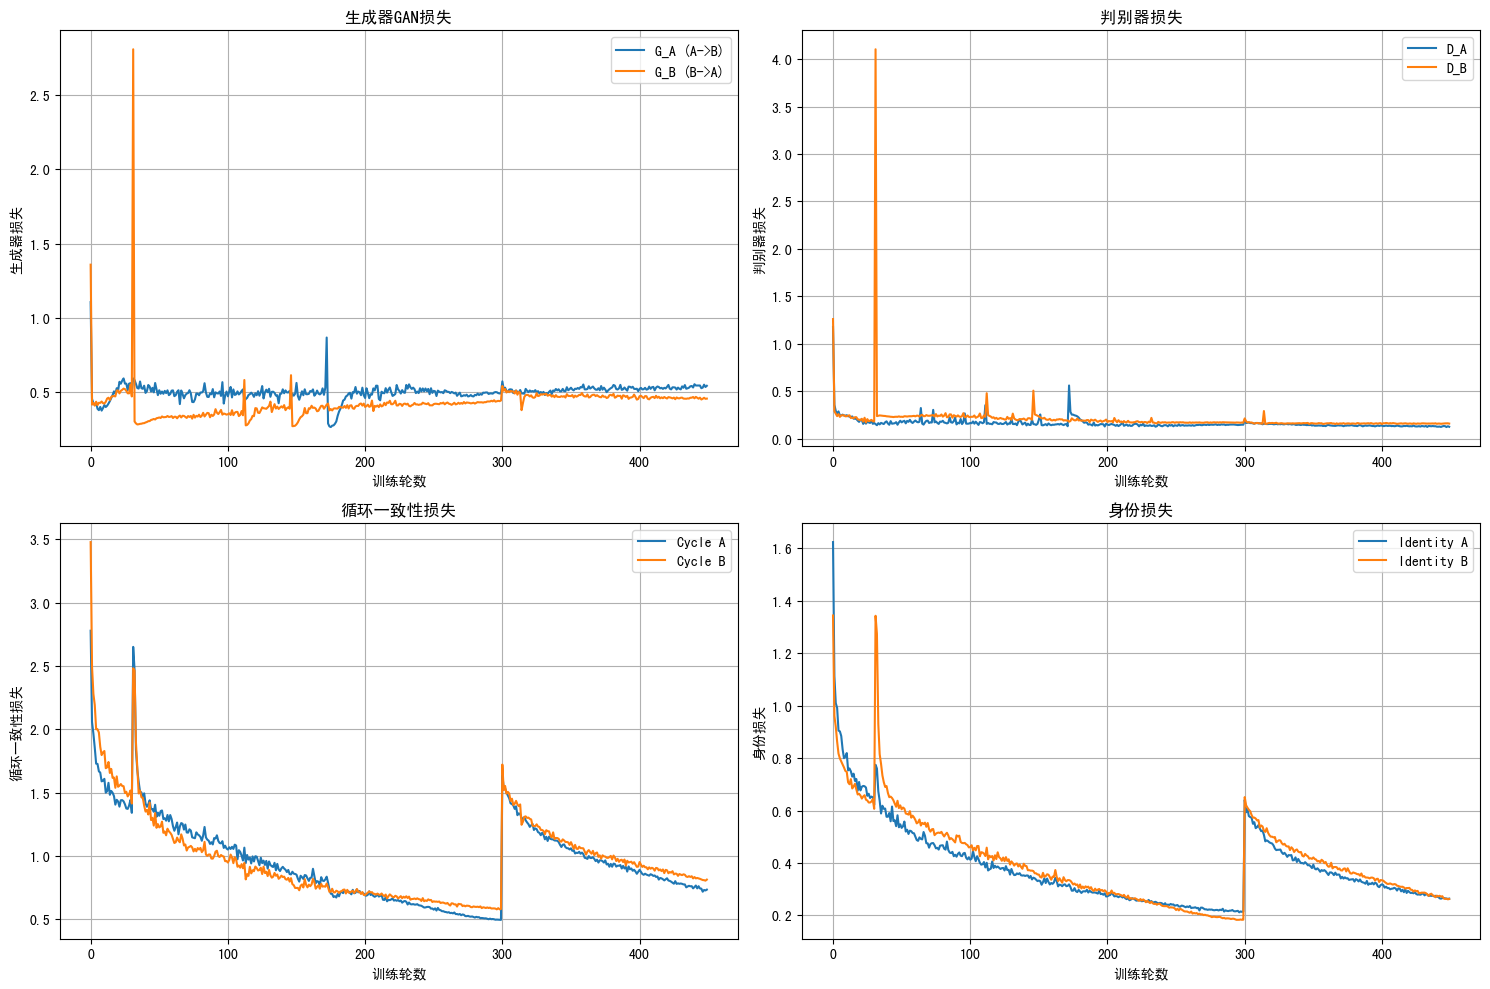

In [16]:
# 绘制损失曲线
plt.figure(figsize=(15, 10))

# 生成器损失
plt.subplot(2, 2, 1)
plt.plot(losses_history['G_A'], label='G_A (A->B)')
plt.plot(losses_history['G_B'], label='G_B (B->A)')
plt.xlabel('训练轮数')
plt.ylabel('生成器损失')
plt.title('生成器GAN损失')
plt.legend()
plt.grid(True)

# 判别器损失
plt.subplot(2, 2, 2)
plt.plot(losses_history['D_A'], label='D_A')
plt.plot(losses_history['D_B'], label='D_B')
plt.xlabel('训练轮数')
plt.ylabel('判别器损失')
plt.title('判别器损失')
plt.legend()
plt.grid(True)

# 循环一致性损失
plt.subplot(2, 2, 3)
plt.plot(losses_history['cycle_A'], label='Cycle A')
plt.plot(losses_history['cycle_B'], label='Cycle B')
plt.xlabel('训练轮数')
plt.ylabel('循环一致性损失')
plt.title('循环一致性损失')
plt.legend()
plt.grid(True)

# 身份损失
plt.subplot(2, 2, 4)
plt.plot(losses_history['idt_A'], label='Identity A')
plt.plot(losses_history['idt_B'], label='Identity B')
plt.xlabel('训练轮数')
plt.ylabel('身份损失')
plt.title('身份损失')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('results/cyclegan/损失曲线.png', dpi=300)
plt.show()

从训练损失曲线可以看到，cycle_loss 在第 301 轮继续训练时出现了明显的飙升，经过 450 轮训练后，模型表现反而不如 300 轮时。

造成这一现象的主要原因，是我们在云端 GPU 训练时保存的模型只包含了权重和训练历史，并未保存优化器的状态。这导致继续训练时优化器参数未能正确衔接，出现了训练波动。

考虑到本 Notebook 主要用于模型复现和流程整合（实际上是因为云 GPU 太贵了，而本地训练又太耗时），对模型性能不做很高的要求，因此这里不再补充保存和恢复优化器状态的相关代码。如有需要，欢迎开发者自行完善相关功能进行测试。

## 6.样本测试

In [17]:
# 定义测试函数
def test_model(test_data_path=None, num_samples=5):
    """测试训练好的模型"""
    netG_A.eval()
    netG_B.eval()
    
    if test_data_path is None:
        # 创建测试数据集，使用确定性变换
        test_dataset = UnalignedDataset(data_root, transform=test_transform, unaligned=False)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        samples = list(test_loader)[-num_samples:]
    else:
        # 从指定路径加载测试数据
        pass
    
    with torch.no_grad():
        plt.figure(figsize=(15, 3 * num_samples))
        for i, data in enumerate(samples):
            real_A = data['A'].to(device)
            real_B = data['B'].to(device)
            
            # 生成转换
            fake_B = netG_A(real_A)
            fake_A = netG_B(real_B)
            
            # 循环重建
            rec_A = netG_B(fake_B)
            rec_B = netG_A(fake_A)
            
            # 转换为图像
            def tensor_to_image(tensor):
                tensor = tensor.cpu().squeeze()
                tensor = (tensor + 1) / 2
                tensor = tensor.clamp(0, 1)
                if tensor.shape[0] == 3:
                    tensor = tensor.permute(1, 2, 0)
                return tensor.numpy()
            
            # 显示结果
            images = [
                ('Real A', tensor_to_image(real_A[0])),
                ('A→B (Fake B)', tensor_to_image(fake_B[0])),
                ('B→A→B (Reconstructed)', tensor_to_image(rec_B[0])),
                ('Real B', tensor_to_image(real_B[0])),
                ('B→A (Fake A)', tensor_to_image(fake_A[0])),
                ('A→B→A (Reconstructed)', tensor_to_image(rec_A[0]))
            ]
            
            for j, (title, img) in enumerate(images):
                plt.subplot(num_samples, 6, i*6 + j + 1)
                plt.imshow(img)
                plt.title(title, fontsize=10)
                plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('results/cyclegan/测试结果.png', dpi=600, bbox_inches='tight')
        plt.show()

数据集A: 777张图像
数据集B: 777张图像


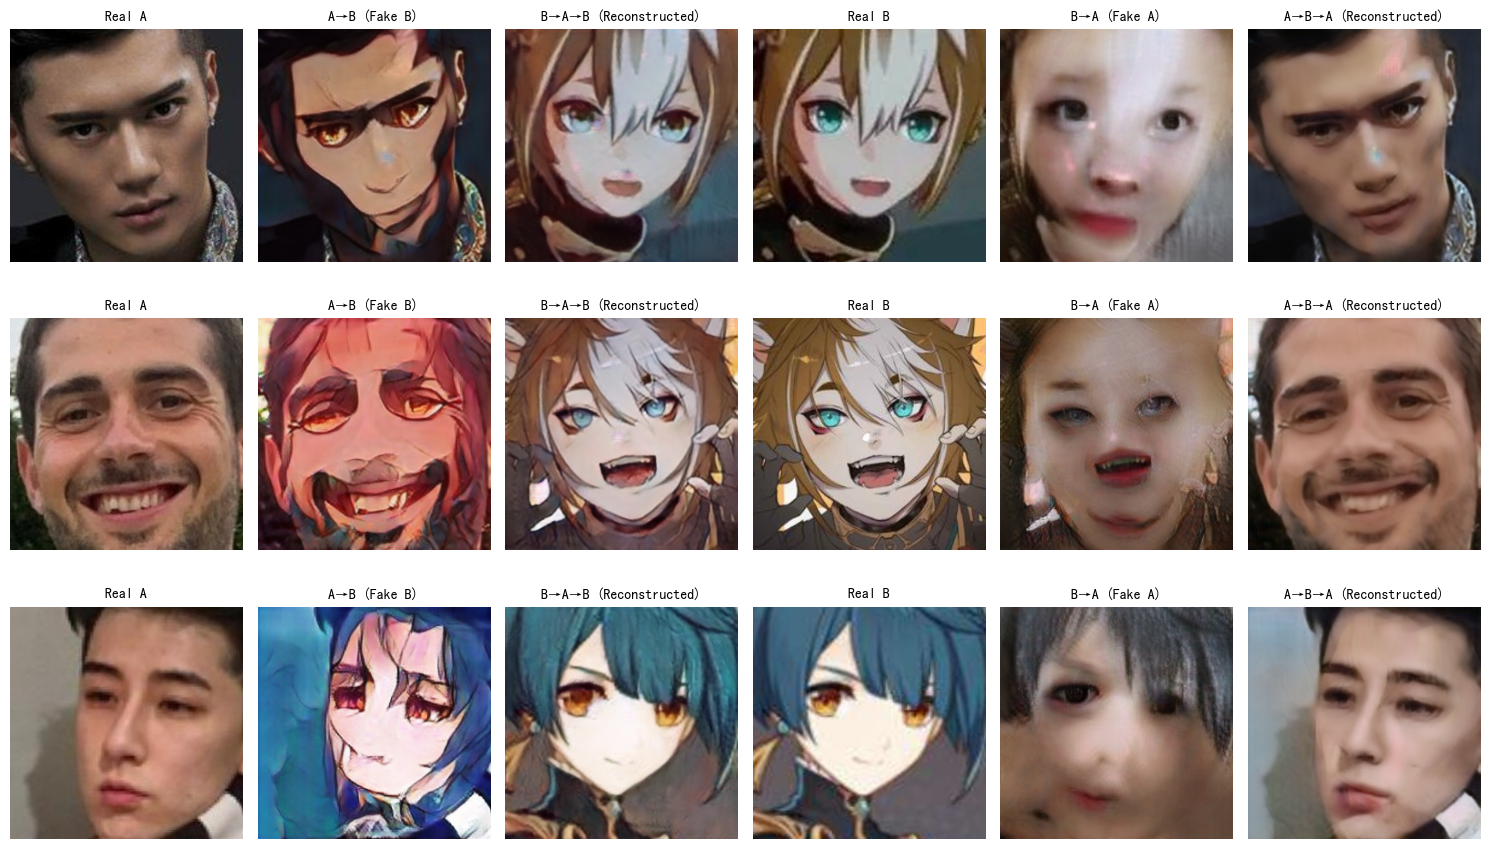


训练完成！模型已保存到 checkpoints/cyclegan_final1.pth
测试结果已保存到 results/cyclegan/ 目录


In [18]:
# 运行测试
test_model(num_samples=3)
print("\n训练完成！模型已保存到 checkpoints/cyclegan_final1.pth")
print("测试结果已保存到 results/cyclegan/ 目录")

显然结果是一坨……抛开训练细节把控，我们猜测其主要原因大概率是数据集质量问题，数据量小且收集质量一般。

而我们使用这个数据集，原因是本notebook主要作者`EruditionHerta`想夹带私货，所以找了一个原神角色的图片数据集。

如果各位开发者想要实现高质量的风格迁移，请考虑优化cycleGAN或尝试Diffusion、Flow Matching等前沿方法，或对CycleGAN进行改进。**当然，最主要的是，用一份更高质量的训练集！**

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# 创建路径
import os
data_root = "./data"
os.makedirs(data_root, exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor()
])

print(f"正在加载CIFAR-10数据集从 {data_root}...")
cifar_dataset = datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform)

正在加载CIFAR-10数据集从 ./data...
Files already downloaded and verified
